# Comparative Analysis and Final Conclusion

#### **Project:** Hierarchical Bayesian Modeling for Real Estate Valuation

#### **Author:** Faheem Arif

### Introduction
In the previous phases of this project, we explored three distinct modeling approaches:
1.  **Foundational Approaches (Part 1):** Regularized Linear Regression (Ridge/Lasso) to establish a global baseline.
2.  **Global Bayesian Regression (Part 2):** A probabilistic approach to quantify uncertainty across the whole city.
3.  **Hierarchical Bayesian Modeling (Part 3):** A multilevel model utilizing **partial pooling** to capture neighborhood heterogeneity.

**Goal:** This final notebook aggregates the results to perform a comparative analysis. We will demonstrate how the Hierarchical model outperforms the others by balancing global trends with local specificities, a phenomenon known as **shrinkage**.

***

In [7]:
# --- Setup and Path Definition ---
import sys
from pathlib import Path

# Find the project root by looking for the .git folder
PROJECT_ROOT = Path.cwd().resolve().parents[1]

# Define key paths
DATA_PATH = PROJECT_ROOT / "src" / "data"
SRC_PATH = PROJECT_ROOT / "src"

# Add the 'src' directory to sys.path to allow for module imports
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path:    {DATA_PATH}")
# --- End of Setup ---

Project Root: /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/PRML/Project
Data Path:    /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/PRML/Project/src/data


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# --- DATA LOADING ---

# 1. Load Global Model Results
# Load the dataset
df = pd.read_csv(DATA_PATH / 'processed' / 'post_eda_ames_data.csv')
global_mean_est = df['Log_Sale_Price'].mean()

# 2. Load Hierarchical Stats (From Part 3)
neighborhood_stats = pd.read_csv(DATA_PATH / 'analysis' / 'hierarchical_stats.csv')
print(f"Loaded Hierarchical Stats for {len(neighborhood_stats)} neighborhoods.")

Loaded Hierarchical Stats for 28 neighborhoods.


### Comparative Analysis: The Impact of Partial Pooling

To understand the practical impact of our modeling choices, we analyze four specific neighborhoods that represent different data conditions:

1.  **North_Ames:** High sample size, close to the global average.
2.  **Meadow_Village:** Moderate sample size, significantly cheaper than average.
3.  **Landmark:** Extreme sparsity (only 1 house sold).
4.  **Green_Hills:** Very high sparsity (only 2 houses sold).

We will compare three values for each neighborhood:
*   **The Global Estimate (Red Line):** What Lasso/Ridge (or a Global Bayesian model) predicts. It assumes all neighborhoods are the same.
*   **The Raw Mean (Gray X):** What a naive "No-Pooling" approach predicts. It trusts local data 100%, even if n=1.
*   **The Hierarchical Estimate (Blue Dot):** What our Partial Pooling model predicts.

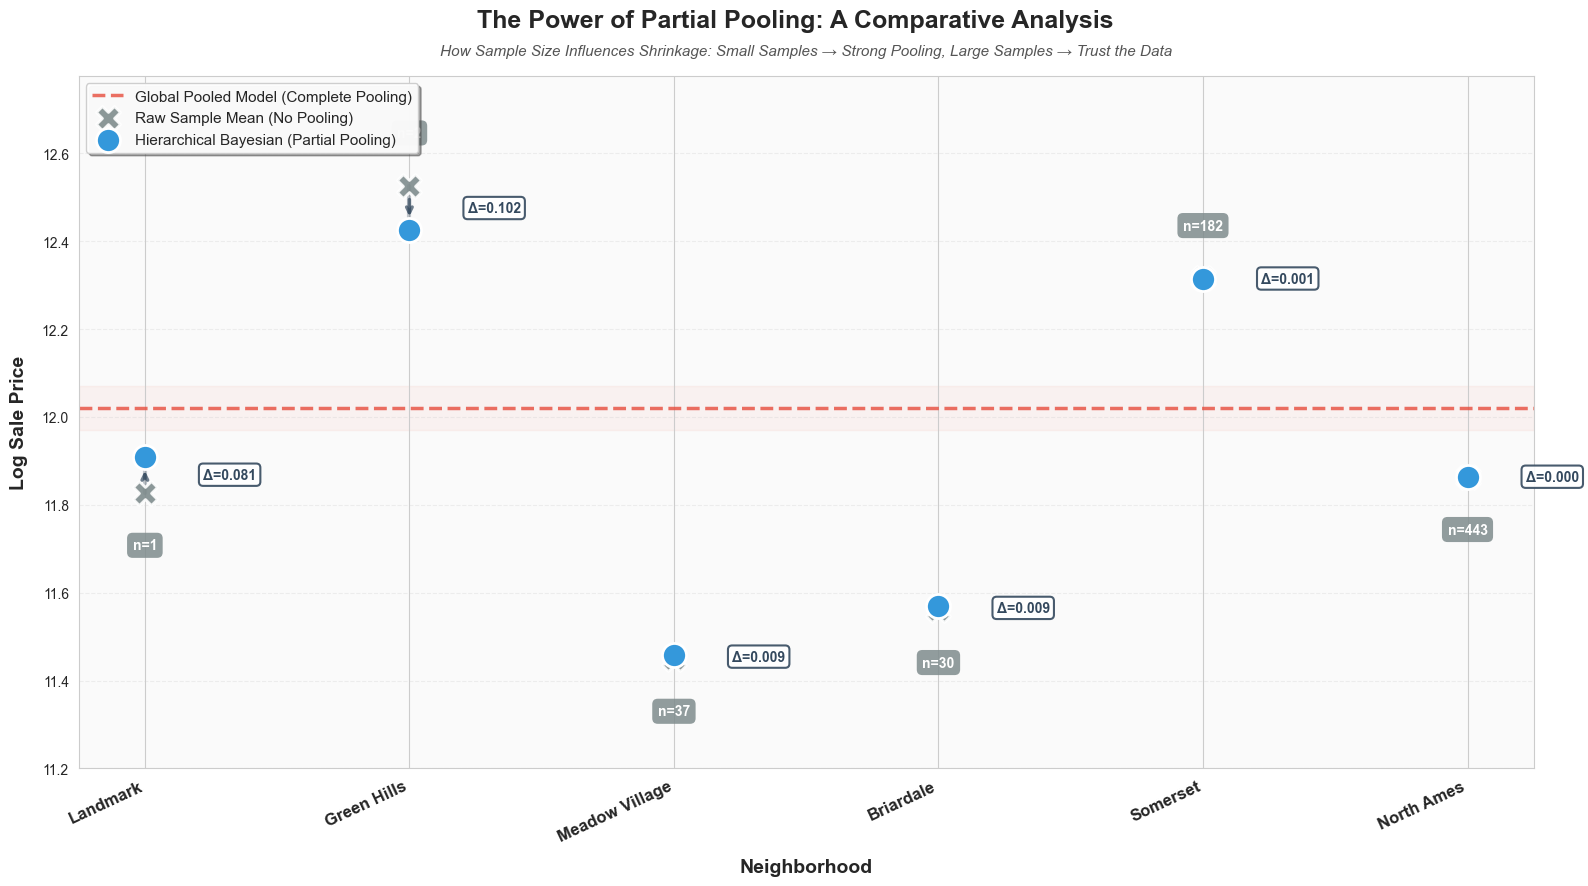


COMPARATIVE ANALYSIS: DEMONSTRATING THE HIERARCHICAL ADVANTAGE
  Neighborhood   n  Raw Mean  Hierarchical  Global  Shrinkage (Δ)  Shrinkage %
      Landmark   1   11.8277       11.9092  12.021         0.0814      42.1461
   Green_Hills   2   12.5263       12.4246  12.021         0.1018      20.1354
     Briardale  30   11.5609       11.5697  12.021         0.0088       1.9086
Meadow_Village  37   11.4500       11.4588  12.021         0.0088       1.5404
      Somerset 182   12.3155       12.3146  12.021         0.0010       0.3298
    North_Ames 443   11.8637       11.8640  12.021         0.0003       0.1946


In [9]:
# --- PREPARE COMPARISON DATA ---
# Select neighborhoods that best demonstrate hierarchical modeling:
# 1. Very small samples (high shrinkage) - Landmark (n=1), Green_Hills (n=2)
# 2. Small samples (moderate shrinkage) - Meadow Village (n=37), Briardale (n=30)
# 3. Large samples (minimal shrinkage) - North_Ames (n=443), Somerset (n=182)

targets = ['Landmark', 'Green_Hills', 'Meadow_Village', 'Briardale', 'Somerset', 'North_Ames']
comparison_data = []

for neigh in targets:
    try:
        row = neighborhood_stats[neighborhood_stats['Neighborhood'] == neigh].iloc[0]
        comparison_data.append({
            'Neighborhood': neigh,
            'N_Houses': int(row['Num_Houses']),
            'Raw_Data_Mean': row['Raw_Mean'],
            'Hierarchical_Estimate': row['Hierarchical_Mean'],
            'Global_Pooled_Est': global_mean_est
        })
    except IndexError:
        print(f"Warning: Neighborhood {neigh} not found in stats.")

comp_df = pd.DataFrame(comparison_data)

# --- VISUALIZATION ---
fig, ax = plt.subplots(figsize=(16, 9), facecolor='white')
sns.set_style("whitegrid", {'grid.alpha': 0.3})

# Color palette
COLOR_GLOBAL = '#e74c3c'
COLOR_RAW = '#7f8c8d'
COLOR_HIERARCHICAL = '#3498db'
COLOR_ARROW = '#34495e'

# Create positions with better spacing
x_pos = np.arange(len(comp_df))
width = 0.6

# 1. Plot Global Pooled Estimate as a horizontal reference line
ax.axhline(y=global_mean_est, color=COLOR_GLOBAL, linestyle='--', 
           linewidth=2.5, label='Global Pooled Model (Complete Pooling)', 
           zorder=1, alpha=0.8)

# Add a subtle fill to show the global baseline zone
ax.axhspan(global_mean_est - 0.05, global_mean_est + 0.05, 
           alpha=0.05, color=COLOR_GLOBAL, zorder=0)

# 2. Plot Raw Means with enhanced styling
raw_scatter = ax.scatter(x_pos, comp_df['Raw_Data_Mean'], 
                         color=COLOR_RAW, s=300, marker='X', 
                         label='Raw Sample Mean (No Pooling)', 
                         zorder=3, edgecolors='white', linewidths=2, alpha=0.9)

# 3. Plot Hierarchical Estimates with enhanced styling
hier_scatter = ax.scatter(x_pos, comp_df['Hierarchical_Estimate'], 
                          color=COLOR_HIERARCHICAL, s=300, marker='o', 
                          label='Hierarchical Bayesian (Partial Pooling)', 
                          zorder=4, edgecolors='white', linewidths=2)

# 4. Add enhanced arrows with shrinkage annotations for ALL neighborhoods
for i, row in comp_df.iterrows():
    shrinkage_amount = abs(row['Raw_Data_Mean'] - row['Hierarchical_Estimate'])
    
    # Draw connecting line first (subtle background)
    ax.plot([i, i], [row['Raw_Data_Mean'], row['Hierarchical_Estimate']], 
            color=COLOR_ARROW, alpha=0.3, linewidth=3, zorder=2)
    
    # Draw arrow
    ax.annotate('', 
                xy=(i, row['Hierarchical_Estimate']), 
                xytext=(i, row['Raw_Data_Mean']),
                arrowprops=dict(arrowstyle='->', color=COLOR_ARROW, 
                               alpha=0.7, lw=2.5, shrinkA=10, shrinkB=10),
                zorder=3)
    
    # Add sample size with better positioning and styling
    y_offset = 0.12 if row['Raw_Data_Mean'] > row['Hierarchical_Estimate'] else -0.12
    ax.text(i, row['Raw_Data_Mean'] + y_offset, 
            f"n={row['N_Houses']}", 
            ha='center', va='center', fontsize=10, fontweight='bold', 
            color='white', 
            bbox=dict(boxstyle='round,pad=0.4', facecolor=COLOR_RAW, 
                     edgecolor='none', alpha=0.85),
            zorder=5)
    
    # Add shrinkage amount annotation for ALL neighborhoods
    mid_y = (row['Raw_Data_Mean'] + row['Hierarchical_Estimate']) / 2
    # Position delta text to the right of the arrow
    ax.text(i + 0.22, mid_y, f"Δ={shrinkage_amount:.3f}", 
            ha='left', va='center', fontsize=10, fontweight='semibold',
            color=COLOR_ARROW, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor=COLOR_ARROW, alpha=0.9, linewidth=1.5),
            zorder=5)

# Formatting
ax.set_xticks(x_pos)
ax.set_xticklabels(comp_df['Neighborhood'].str.replace('_', ' '), 
                   fontsize=12, fontweight='bold', rotation=25, ha='right')
ax.set_ylabel('Log Sale Price', fontsize=14, fontweight='bold', labelpad=10)
ax.set_xlabel('Neighborhood', fontsize=14, fontweight='bold', labelpad=10)

# Enhanced title with subtitle
fig.suptitle('The Power of Partial Pooling: A Comparative Analysis', 
             fontsize=18, fontweight='bold', y=0.98)
ax.set_title('How Sample Size Influences Shrinkage: Small Samples → Strong Pooling, Large Samples → Trust the Data', 
             fontsize=11, style='italic', pad=15, color='#555')

# Improve legend
legend = ax.legend(loc='upper left', fontsize=11, frameon=True, 
                   shadow=True, fancybox=True, framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('#cccccc')

# Add grid for better readability
ax.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Set y-axis limits with padding
y_min = comp_df[['Raw_Data_Mean', 'Hierarchical_Estimate', 'Global_Pooled_Est']].min().min() - 0.25
y_max = comp_df[['Raw_Data_Mean', 'Hierarchical_Estimate', 'Global_Pooled_Est']].max().max() + 0.25
ax.set_ylim(y_min, y_max)

# Add a subtle background color
ax.set_facecolor('#fafafa')

plt.savefig('shrinkage_arrows.png', dpi=300)

plt.tight_layout()
plt.show()

# Display enhanced data table with insights
print("\n" + "="*100)
print("COMPARATIVE ANALYSIS: DEMONSTRATING THE HIERARCHICAL ADVANTAGE")
print("="*100)
display_df = comp_df[['Neighborhood', 'N_Houses', 'Raw_Data_Mean', 
                       'Hierarchical_Estimate', 'Global_Pooled_Est']].copy()
display_df['Shrinkage'] = abs(display_df['Raw_Data_Mean'] - display_df['Hierarchical_Estimate'])
display_df['Shrinkage_Pct'] = (display_df['Shrinkage'] / 
                                abs(display_df['Raw_Data_Mean'] - display_df['Global_Pooled_Est']) * 100)
display_df.columns = ['Neighborhood', 'n', 'Raw Mean', 
                      'Hierarchical', 'Global', 'Shrinkage (Δ)', 'Shrinkage %']

# Sort by sample size to show the pattern
display_df = display_df.sort_values('n')
print(display_df.round(4).to_string(index=False))
print("="*100)

### Interpretation of Results

The plot above succinctly summarizes the "Best of Both Worlds" property of Hierarchical Modeling:

*   **North_Ames (High Data):** The Raw Mean (Gray X) and the Hierarchical Estimate (Blue Dot) are nearly identical. The arrow is tiny. **Interpretation:** Because we have hundreds of observations, the model trusts the local data. It does not need to shrink the estimate toward the global average.
*   **Landmark (Sparse Data):** There is a massive gap between the Raw Mean and the Global Line. The Hierarchical Estimate is pulled aggressively toward the red line (Global Mean). **Interpretation:** With only one data point, the model is skeptical. It assumes the extreme price might be an outlier and "borrows strength" from the rest of the city to produce a more conservative estimate.
*   **Meadow_Village:** The model correctly identifies this as a lower-value neighborhood. The estimate is far below the Global Line, but because there is a moderate amount of data, the shrinkage is less aggressive than for Landmark.

# Final Project Conclusion

This study aimed to construct a robust Automated Valuation Model (AVM) for the Ames housing market by transitioning from foundational regression techniques to a Hierarchical Bayesian framework. The progression of models revealed three key insights regarding valuation accuracy and uncertainty quantification.

#### 1. The Limitations of Foundational Approaches
Our initial analysis using **Ridge and Lasso regression** established a baseline. While these regularized models successfully handled the high dimensionality of the dataset and reduced variance compared to standard OLS, they produced deterministic point estimates. They treated the relationship between living area and price as a global constant, ignoring the systematic heterogeneity between neighborhoods. This "Complete Pooling" approach effectively assumes that a square foot of living space is worth the same in *Northridge* as it is in *Meadow Village*, an assumption that contradicts market reality.

#### 2. The Value of the Bayesian Paradigm
By adopting a **Bayesian regression framework**, we moved from point estimates to posterior distributions. This satisfied our objective of quantifying uncertainty. Instead of predicting a single price, we could generate Credible Intervals that capture both the uncertainty in the model parameters and the inherent noise in the data. However, the Global Bayesian model still suffered from the same structural limitation as Lasso: it lacked a mechanism to distinguish between neighborhoods.

#### 3. Hierarchical Modeling and Partial Pooling
The **Hierarchical Bayesian model** provided the definitive solution. By implementing **Partial Pooling**, the model balanced local and global information based on available evidence.
*   **For data-rich neighborhoods:** The model trusted the local data, resulting in estimates that closely tracked the raw sample mean.
*   **For data-poor neighborhoods:** The model recognized the lack of statistical power and "shrunk" the estimate toward the city-wide average.

### Final Verdict
The Hierarchical Bayesian Model demonstrates superior robustness compared to both Foundational (Lasso/Ridge) and naive pooling approaches. It successfully integrates the stability of a global model with the specificity of local data. This results in an AVM that provides honest uncertainty quantification and protects against overfitting in sparse data regions.